## 10th Question Answering over Linked Data (QALD) Challenge @ ESWC 2022Permalink

## Task 1: Multilingual Question Answering over Knowledge GraphsPermalink

### Participants (Skolkovo Institute of Science and Technology, Skoltech):

1. Nikita Baramiia

1. Alina Rogulina

1. Sergey Petrakov

1. Valerii Kornilov

## Requirements

## (All other requirements are satisfied in kaggle docker 2022.05.20)

In [1]:
# pip install scann wikidata sentencepiece

In [2]:
# pip install numpy --upgrade

## Imports

In [3]:
import re

import os
import time
import json
import ijson
import scann
import numpy as np
import pandas as pd

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from pytorch_metric_learning import losses

from wikidata.client import Client

from tqdm import tqdm

import gc
gc.collect()

device = torch.device('cpu') # torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Prepare dictionaries of Q-items and P-properties

There is if-condition in Q-dict preparation connected with RAM constraints: 

if you have enougth RAM, you can prepare full dictionary for experiments (but results were rather similar in our case).

In [4]:
DATA_PATH = "./data"

In [5]:
Qs = {} # 4 106 846 it -- total
BREAK_AFTER_N = None

with open(os.path.join(DATA_PATH, "Q_embeddings.json"), "rb") as f:
    if BREAK_AFTER_N is not None:
        i = 0
    for key, value in tqdm(ijson.kvitems(f, '')):
        Qs[key] = torch.Tensor(value)
        if BREAK_AFTER_N is not None:
            i += 1
            if i == BREAK_AFTER_N:
                break

Qs_keys = set(Qs.keys())

Qs_ordered_site = np.array(list(Qs.keys()))
Qs_ordered_embs = np.stack(list(Qs.values()), axis=0)

Ps = {} # 

with open(os.path.join(DATA_PATH, "P_embeddings.json"), "rb") as f:
    for key, value in tqdm(ijson.kvitems(f, '')):
        Ps[key] = torch.Tensor(value)

Ps_keys = set(Ps.keys())

Ps_ordered_site = np.array(list(Ps.keys()))
Ps_ordered_embs = np.stack(list(Ps.values()), axis=0)

999it [00:00, 5125.33it/s]
5926it [00:01, 4549.29it/s]


## ScaNN fit (for approximate neigbours search)

In [6]:
start = time.time()

Q_searcher = scann.scann_ops_pybind.builder(Qs_ordered_embs, 5, "dot_product").tree(
    num_leaves=int(np.sqrt(len(Qs_ordered_embs))), 
    num_leaves_to_search=int(np.sqrt(len(Qs_ordered_embs)) // 10), 
    training_sample_size=int(len(Qs_ordered_embs) // 20)
).score_ah(2, anisotropic_quantization_threshold=0.2).reorder(100).build()

P_searcher = scann.scann_ops_pybind.builder(Ps_ordered_embs, 5, "dot_product").tree(
    num_leaves=int(np.sqrt(len(Ps_ordered_embs))), 
    num_leaves_to_search=int(np.sqrt(len(Ps_ordered_embs)) // 10), 
    training_sample_size=int(len(Ps_ordered_embs) // 20)
).score_ah(2, anisotropic_quantization_threshold=0.2).reorder(100).build()

end = time.time()
print("Time:", end - start)

Time: 2.199733257293701


## Train/test preprocessing

### train

In [7]:
QA_train = pd.DataFrame(columns=['question', 'query', 'answer'])

with open(os.path.join(DATA_PATH, "qald_9_plus_train_wikidata.json"), "rb") as f:
    for el in tqdm(ijson.items(f, 'questions.item')):
        QA_train.loc[int(el['id']), 'question'] = el['question'][0]['string'] # el['question']
        
        # for simplicity we parse only certain format of sparql like in https://www.nliwod.org/challenge
        res = re.findall(r'<.*?>', el['query']['sparql'])
        QA_train.loc[int(el['id']), 'query'] = [
            (
                res[i*2].strip('<>').replace('http://www.wikidata.org/entity/', '').replace('http://www.wikidata.org/prop/direct/', ''), 
                res[i*2 + 1].strip('<>').replace('http://www.wikidata.org/prop/direct/', '').replace('http://www.wikidata.org/entity/', '')
            ) for i in range(len(res) // 2)
        ] if len(res) >= 2 else None
        
        key = list(el['answers'][0]['results']['bindings'][0].keys())[0]
        QA_train.loc[int(el['id']), 'answer'] = [
            list_val[key]['value'].replace('http://www.wikidata.org/entity/', '') \
            for list_val in el['answers'][0]['results']['bindings']
        ]

print(f'Shape before cleaning: {QA_train.shape}')

# then we drop all Nones
QA_train['query'] = QA_train['query'].apply(
    lambda x: [
        tuple(sorted(list(t), key=lambda x: x[0], reverse=True))
        if ((t[0] != '') and (t[1] != '') and (t[0][0] != t[1][0]) and (t[0][0] != 'h') and (t[1][0] != 'h')) else None 
        for t in x
] if x is not None else x)

QA_train['query'] = QA_train['query'].apply(lambda row: [x for x in row if x is not None] if row is not None else row)
QA_train = QA_train.loc[QA_train['query'].apply(lambda x: x != [])]

QA_train.dropna(inplace=True)

print(f'Shape after cleaning: {QA_train.shape}')

412it [00:01, 369.11it/s]

Shape before cleaning: (412, 3)
Shape after cleaning: (145, 3)


### test

In [8]:
QA_test = pd.DataFrame(columns=['question'])

with open(os.path.join(DATA_PATH, "qald_10.json"), "rb") as f:
    for el in tqdm(ijson.items(f, 'questions.item')):
        QA_test.loc[int(el['id']), 'question'] = el['question'][0]['string']

394it [00:00, 1397.32it/s]


## Classes for our model and scheduler with early stopping

In [20]:
from transformers import (
    BartTokenizer, BartModel, MBart50Tokenizer,
    BertTokenizer, BertModel,
    XLMRobertaTokenizer, XLMRobertaModel
)

class AnswerPredictor(nn.Module):
    def __init__(self, base_model_name='bart', embed_size=200):
        super().__init__()
        
        self.base_model_name = base_model_name
        
        if 'bart' in self.base_model_name:
            if self.base_model_name == 'bart':
                name = 'facebook/bart-base'
                self.tokenizer = BartTokenizer.from_pretrained(name)
            elif self.base_model_name == 'mbart':
                name = 'facebook/mbart-large-50'
                self.tokenizer = MBart50Tokenizer.from_pretrained(name)
            self.model = BartModel.from_pretrained(name).to(device)
        elif 'bert' in self.base_model_name:
            name = 'bert-base-uncased' if self.base_model_name == 'bert' else 'bert-base-multilingual-uncased'
            self.tokenizer = BertTokenizer.from_pretrained(name)
            self.model = BertModel.from_pretrained(name).to(device)
        elif 'xlm-r' in self.base_model_name:
            name = 'xlm-roberta-base' if self.base_model_name == 'xlm-r' else 'sentence-transformers/stsb-xlm-r-multilingual'
            self.tokenizer = XLMRobertaTokenizer.from_pretrained(name)
            self.model = XLMRobertaModel.from_pretrained(name).to(device)

        self.linear_map = nn.Linear(in_features=768, out_features=embed_size*2).to(device)
    
    def forward(self, inputs):
        inputs = self.tokenizer(inputs, return_tensors="pt", padding=True).to(device)
        outputs = self.model(**inputs)
        
        return self.linear_map(torch.mean(outputs.last_hidden_state, dim=1))


class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=6, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
            print("self.best_loss == None")
            print("best_loss", self.best_loss)
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
            print("self.best_loss - val_loss > self.min_delta")
            print("counter", self.counter)
        elif self.best_loss - val_loss < self.min_delta:
            print("self.best_loss - val_loss < self.min_delta")
            print("counter", self.counter)
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

class StepLRWithWarmup(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, step_size, gamma=0.1, warmup_epochs=2, warmup_lr_init=1e-5,
                 min_lr=1e-5,
                 last_epoch=-1, verbose=False):
        self.step_size = step_size
        self.gamma = gamma
        self.warmup_epochs = warmup_epochs
        self.warmup_lr_init = warmup_lr_init
        self.min_lr = min_lr

        super(StepLRWithWarmup, self).__init__(optimizer, last_epoch, verbose)

    def get_lr(self):
        if not self._get_lr_called_within_step:
            warnings.warn("To get the last learning rate computed by the scheduler, "
                          "please use `get_last_lr()`.", UserWarning)
        if self.last_epoch == 0:
            return [self.warmup_lr_init]
        
        number = self.optimizer.param_groups[0]['initial_lr']
        if self.last_epoch in range(self.warmup_epochs):
            # 1) scheduler is in warm-up mode and learning rate should lineary increase during epochs
            # from self.warmup_lr_init to self.base_lrs (self.optimizer.param_groups[0]['lr'] in our case)
            return [self.warmup_lr_init + self.last_epoch * (number - self.warmup_lr_init) / (self.warmup_epochs)]
        
        elif self.last_epoch == self.warmup_epochs:
            # 2) self.last_epoch is equal to self.warmup_epochs, then just return self.base_lrs
            
            return [self.optimizer.param_groups[0]['initial_lr']]
        
        elif ((self.last_epoch - self.warmup_epochs) % self.step_size != 0):
            # 3) self.last_epoch - self.warmup_epochs is not divisible by self.step_size then
            # just return the previous learning rate
            return [group['lr'] for group in self.optimizer.param_groups]
        
        elif ((self.last_epoch - self.warmup_epochs) % self.step_size == 0) & (self.optimizer.param_groups[0]['lr'] * self.gamma >= self.min_lr):
            # 4) self.last_epoch - self.warmup_epochs is divisible by self.step_size and the
            # current learning rate multiplied by self.gamma is not less then self.min_lr,
            # then multiply it and return the new value
            return [group['lr'] * self.gamma for group in self.optimizer.param_groups]
        
        elif (self.optimizer.param_groups[0]['lr'] * self.gamma < self.min_lr) :
            # Otherwise just return the last learning rate
            return [self.min_lr]

## Training process

In [21]:
sentences_train = QA_train.question.values # QA_train.Q.apply(lambda x: x[0]['string']).values
sentences_test  = QA_test.question.values  # QA_test.Q.apply( lambda x: x[0]['string']).values

queries_train = QA_train['query'].values # answers_train = QA_train.A.values

len(sentences_train), len(queries_train), len(sentences_test)

# Parameters
embedding_size = 200
losses_bart = []
BASE_MODEL_NAME = 'mxlm-r'
model = AnswerPredictor(base_model_name=BASE_MODEL_NAME, embed_size=embedding_size)

train_size = len(sentences_train)
batch_size = 128 # 16, 32, 64
n_epochs = 200


optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-5)

# LRscheduler
lr_scheduler = StepLRWithWarmup(optimizer = optimizer, step_size = 13, gamma=0.9, warmup_epochs=2,
                                warmup_lr_init=1e-5, min_lr=1e-5, last_epoch=-1, verbose=False)

# Triplet loss
metric_loss = nn.TripletMarginLoss()


#######
# train
#######
losses_bart = []
early_stopping = EarlyStopping(patience=10)
for i in tqdm(range(n_epochs)):
    # get shuffled train indices
    indices_shuffled = np.random.choice(train_size, size=train_size, replace=False)
    
    loss_val = 0
    for i in range(train_size // batch_size):
        optimizer.zero_grad()
        
        # get batch
        indices_batch = indices_shuffled[i*batch_size:(i+1)*batch_size]
        sentences_batch, queries_batch = sentences_train[indices_batch], queries_train[indices_batch]
        
        # prepare good keys we drop to find negative examples
        Qs_keys_todrop = set().union(*[ans[0][0] for ans in queries_batch])
        Qs_keys_leaved = Qs_keys - Qs_keys_todrop
        
        Ps_keys_todrop = set().union(*[ans[0][1] for ans in queries_batch])
        Ps_keys_leaved = Ps_keys - Ps_keys_todrop
        
        # predicted embeddings for answers in batch
        queries_anchor = model(list(sentences_batch))
        queries_anchor_copy = queries_anchor.detach().cpu().clone()
        
        # prepare positive samples for batch
        queries_positive = []
        for b, queries_pos in enumerate(queries_batch):
            query_sample = queries_pos[np.random.choice(len(queries_pos), size=1)[0]]
            
            Q_embed = Qs.get(query_sample[0], queries_anchor_copy[b][:embedding_size])
            P_embed = Ps.get(query_sample[1], queries_anchor_copy[b][embedding_size:])
            
            queries_positive.append(torch.cat([Q_embed, P_embed]))
            
        queries_positive = torch.stack(queries_positive, dim=0).to(device)
        
        # prepare negative samples for batch
        neighbors_Q, _ = Q_searcher.search_batched(queries_anchor_copy[:, :embedding_size], leaves_to_search=1000, 
                                                   pre_reorder_num_neighbors=1000, final_num_neighbors=10)
        neighbors_P, _ = P_searcher.search_batched(queries_anchor_copy[:, embedding_size:], leaves_to_search=1000, 
                                                   pre_reorder_num_neighbors=1000, final_num_neighbors=10)
        
        Qs_negative_sites = [
            [
                neg_ex for neg_ex in list(Qs_ordered_site[neighbors_Q[s]]) if neg_ex not in queries_batch[s]
            ][0] for s in range(batch_size)
        ]
        Ps_negative_sites = [
            [
                neg_ex for neg_ex in list(Ps_ordered_site[neighbors_P[s]]) if neg_ex not in queries_batch[s]
            ][0] for s in range(batch_size)
        ]
        
        queries_negative = torch.stack([
            torch.cat([
                Qs.get(neg_Q, queries_anchor_copy[b][:embedding_size]), 
                Ps.get(neg_P, queries_anchor_copy[b][embedding_size:])
            ])
            for b, (neg_Q, neg_P) in enumerate(zip(Qs_negative_sites, Ps_negative_sites))
        ], dim=0).to(device)
        
        # loss calculation and optimization step
        loss = metric_loss(queries_anchor, queries_positive, queries_negative)
        loss_val += loss.item() * batch_size
        loss.backward()
        
        optimizer.step()

    print(f'Loss: {loss_val / train_size}')
    losses_bart.append(loss_val / train_size)
    
    
    early_stopping(loss_val / train_size)
    if early_stopping.early_stop:
        break

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/505 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/709 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

 50%|█████     | 1/2 [00:12<00:12, 12.83s/it]

Loss: 0.20323173259866648
self.best_loss == None
best_loss 0.20323173259866648


100%|██████████| 2/2 [00:22<00:00, 11.35s/it]

Loss: 0.17043345221157732
self.best_loss - val_loss > self.min_delta
counter 0


Plot loss and save model

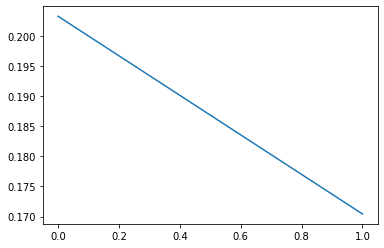

In [22]:
#additionally
# result["BART_100"] = losses_bart

import matplotlib.pyplot as plt
import datetime

plt.plot(losses_bart)

SAVE_NAME = "{}_{}_{}.pth".format(
    BASE_MODEL_NAME, 
    n_epochs, 
    str(datetime.datetime.now()).replace(' ', '-').replace(':', '_').replace('.', '_')
)
SAVE_PATH = './models'
torch.save(model.state_dict(), os.path.join(SAVE_PATH, SAVE_NAME))

Some check

In [12]:
queries = model(['Who killed Caesar?', 'How many planets around the sun?']).detach().cpu().numpy()

In [13]:
start = time.time()
Q_neighbors, _ = Q_searcher.search_batched(queries[:, :embedding_size], leaves_to_search=1000, pre_reorder_num_neighbors=1000)
P_neighbors, _ = P_searcher.search_batched(queries[:, embedding_size:], leaves_to_search=1000, pre_reorder_num_neighbors=1000)
end = time.time()
print("Time:", end - start)

Time: 0.002849578857421875


In [14]:
client = Client()

answer = client.get('Q192115', load=True)[client.get('P162')]
answer.id

'Q465517'

In [15]:
'http://www.wikidata.org/entity/Q465517'

'http://www.wikidata.org/entity/Q465517'

In [16]:
print('Who killed Caesar?')
['http://www.wikidata.org/entity/' + q for q in Qs_ordered_site[Q_neighbors[0]]], \
['http://www.wikidata.org/prop/direct/' + p for p in Ps_ordered_site[P_neighbors[0]]]

Who killed Caesar?


(['http://www.wikidata.org/entity/Q131578',
  'http://www.wikidata.org/entity/Q28350',
  'http://www.wikidata.org/entity/Q21102930',
  'http://www.wikidata.org/entity/Q3018671',
  'http://www.wikidata.org/entity/Q21102970'],
 ['http://www.wikidata.org/prop/direct/P404',
  'http://www.wikidata.org/prop/direct/P400',
  'http://www.wikidata.org/prop/direct/P462',
  'http://www.wikidata.org/prop/direct/P1209',
  'http://www.wikidata.org/prop/direct/P478'])

In [17]:
with open(os.path.join(DATA_PATH, "qald_10.json"), "rb") as f:
    data = json.load(f)

In [18]:
for i in range(len(data['questions'])):
    print(data['questions'][i]['answers'][0])
    break

{'head': {'vars': ['result']}, 'results': {'bindings': [{'result': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q42299'}}]}}


## Inference procedure

In [19]:
for i in tqdm(range(len(data['questions']))):
    num_of_neighs = 3
    
    query = model(sentences_test[i]).detach().cpu().numpy()
    
    Q_neighbors, _ = Q_searcher.search_batched(
        query[:, :embedding_size], leaves_to_search=1000, pre_reorder_num_neighbors=1000, final_num_neighbors=num_of_neighs,
    )
    P_neighbors, _ = P_searcher.search_batched(
        query[:, embedding_size:], leaves_to_search=1000, pre_reorder_num_neighbors=1000, final_num_neighbors=num_of_neighs,
    )
    
    fail = True
    for q in range(num_of_neighs):
        for p in range(num_of_neighs):
            client = Client()
            try:
                if fail:
                    site_pred = client.get(
                        Qs_ordered_site[Q_neighbors[0][q]], load=True
                    )[client.get(Ps_ordered_site[P_neighbors[0][p]])].id

                    data['questions'][i]['answers'][0] = {
                        'head': {'vars': ['result']},
                        'results': {'bindings': []}
                    }
                    data['questions'][i]['answers'][0]['results']['bindings'].append(
                        {'result': {'type': 'uri', 'value': f'http://www.wikidata.org/entity/{site_pred}'}}
                    )
                    
                    data['questions'][i]['query'] = {
                        "sparql": "SELECT DISTINCT ?o1 WHERE { <http://www.wikidata.org/entity/" + \
                        Qs_ordered_site[Q_neighbors[0][q]] + ">  <http://www.wikidata.org/prop/direct/" + \
                        Ps_ordered_site[P_neighbors[0][p]] + ">  ?o1 .  }"
                    }
                    fail = False
            except:
                continue
        
        if fail:
            data['questions'][i]['answers'] = [{'head': {}, 'boolean': True}]
            
            data['questions'][i]['query'] = {
                "sparql": "SELECT DISTINCT ?o1 WHERE { <http://www.wikidata.org/entity/" + \
                Qs_ordered_site[Q_neighbors[0][0]] + ">  <http://www.wikidata.org/prop/direct/" + \
                Ps_ordered_site[P_neighbors[0][0]] + ">  ?o1 .  }"
            }

  9%|▉         | 36/394 [03:14<32:14,  5.40s/it]


KeyboardInterrupt: 

In [ ]:
SUBMIT_PATH = './submissions'
SUBMIT_NAME = '{}.json'.format(SAVE_NAME.split('.')[0])

with open(os.path.join(SUBMIT_PATH, SUBMIT_NAME), 'w') as f:
    json.dump(data, f)

Link corresponed to this submission:

In [ ]:
#link https://gerbil-qa.aksw.org/gerbil/experiment?id=202205210032 